In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import bbknn
import scvelo as scv
import anndata
import leidenalg
import loompy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import rc_context
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import random
import mellon

In [5]:
os.chdir("/opt/work/Python_analysis/")
import scvi

Global seed set to 0


In [29]:
sample_paths = {
    # Young and old data (Sham and Overload)
    'YSham_GFP': '/opt/work/data/Young_Sham_GFP_filtered_feature_bc_matrix.h5',
    'YSham_noGFP': '/opt/work/data/Young_Sham_noGFP_filtered_feature_bc_matrix.h5',
    'YOV_GFP': '/opt/work/data/Young_OV_GFP_filtered_feature_bc_matrix.h5',
    'YOV_noGFP': '/opt/work/data/Young_OV_noGFP_filtered_feature_bc_matrix.h5',
    'ASham_GFP': '/opt/work/data/Aged_Sham_GFP_filtered_feature_bc_matrix.h5',
    'ASham_noGFP': '/opt/work/data/Aged_Sham_noGFP_filtered_feature_bc_matrix.h5',
    'AOV_GFP': '/opt/work/data/Aged_OV_GFP_filtered_feature_bc_matrix.h5',
    'AOV_noGFP': '/opt/work/data/Aged_OV_noGFP_filtered_feature_bc_matrix.h5',
}
    # Satellite cell depleted data and control    
#    'V1': 'P:/Tolulope/Cellranger Results/ALL/v1/outs/filtered_feature_bc_matrix',
#    'V2': 'P:/Tolulope/Cellranger Results/ALL/v2/outs/filtered_feature_bc_matrix',
#    'T1': 'P:/Tolulope/Cellranger Results/ALL/t1/outs/filtered_feature_bc_matrix',
#    'T2': 'P:/Tolulope/Cellranger Results/ALL/t2/outs/filtered_feature_bc_matrix'
#}
samples = list(sample_paths.keys())
#samples[1]
samples[1]

'YSham_noGFP'

In [31]:
adata = []
for i in range(0,len(samples)):
    #adata.append(scv.read_loom('Data/'+samples[i]+'/velocyto/'+samples[i]+'.loom',validate=False))
    adata.append(sc.read_10x_h5(sample_paths[samples[i]]))
    adata[i].var_names_make_unique()
#     results_file = 'Data/'+samples[i]+'/velocyto/'+samples[i]+'_pp.h5ad'
#     adata.append(scv.read(results_file))
adata_concat = anndata.AnnData.concatenate(adata[0],adata[1],adata[2],adata[3],adata[4],adata[5],adata[6],adata[7],batch_categories=samples)
results_file = 'adata_concat.h5ad'
adata_concat.write(results_file)

In [4]:
adata1 = sc.read_10x_h5(sample_paths['YSham_GFP'])
adata2 = sc.read_10x_h5(sample_paths['YSham_noGFP'])
adata3 = sc.read_10x_h5(sample_paths['YOV_GFP'])
adata4 = sc.read_10x_h5(sample_paths['YOV_noGFP'])
adata5 = sc.read_10x_h5(sample_paths['ASham_GFP'])
adata6 = sc.read_10x_h5(sample_paths['ASham_noGFP'])
adata7 = sc.read_10x_h5(sample_paths['AOV_GFP'])
adata8 = sc.read_10x_h5(sample_paths['AOV_noGFP'])

In [13]:
sample_paths['YSham_GFP']
adata1

AnnData object with n_obs × n_vars = 2760 × 23122
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [34]:
#adata = sc.read_10x_h5(sample_paths['YSham_GFP'])
adata=adata_concat.copy()
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_cells(adata, max_genes=3000)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

In [ ]:
sc.pp.neighbors(adata,n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata,resolution=1)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=35,
           title='clustering of cells')

In [36]:
kwargs=dict(verbose=True,plot_convergence=True,max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata,key='batch',**kwargs)
sc.pp.neighbors(adata,use_rep='X_pca_harmony',n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata,resolution=1)

2025-03-03 23:54:22,875 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-03 23:54:29,899 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-03 23:54:30,095 - harmonypy - INFO - Iteration 1 of 10
2025-03-03 23:54:37,487 - harmonypy - INFO - Iteration 2 of 10
2025-03-03 23:54:45,561 - harmonypy - INFO - Iteration 3 of 10
2025-03-03 23:54:53,112 - harmonypy - INFO - Converged after 3 iterations


KeyError: 'groups'

In [37]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)
sc.tl.umap(adata)

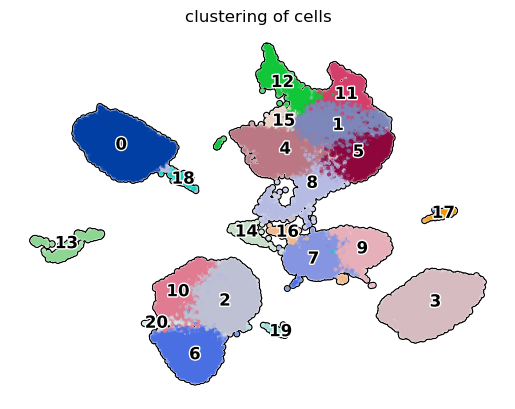

In [38]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=35,
           title='clustering of cells')

In [39]:
adata.write('Harmony_integrated_data.h5ad')
adata_concat=adata.copy()

In [70]:
results_file="Harmony_integrated_data.h5ad"
adata=scv.read(results_file)
adata_concat=adata.copy()

In [43]:
sc.tl.rank_genes_groups(adata_concat,'leiden',method='wilcoxon',n_genes=1000)
result = adata_concat.uns['rank_genes_groups']
groups = result['names'].dtype.names
res = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges','pvals','pvals_adj']})
res.to_csv('integrated_cluster_genes1.csv')

In [72]:
sc.tl.embedding_density(adata_concat, groupby='batch')

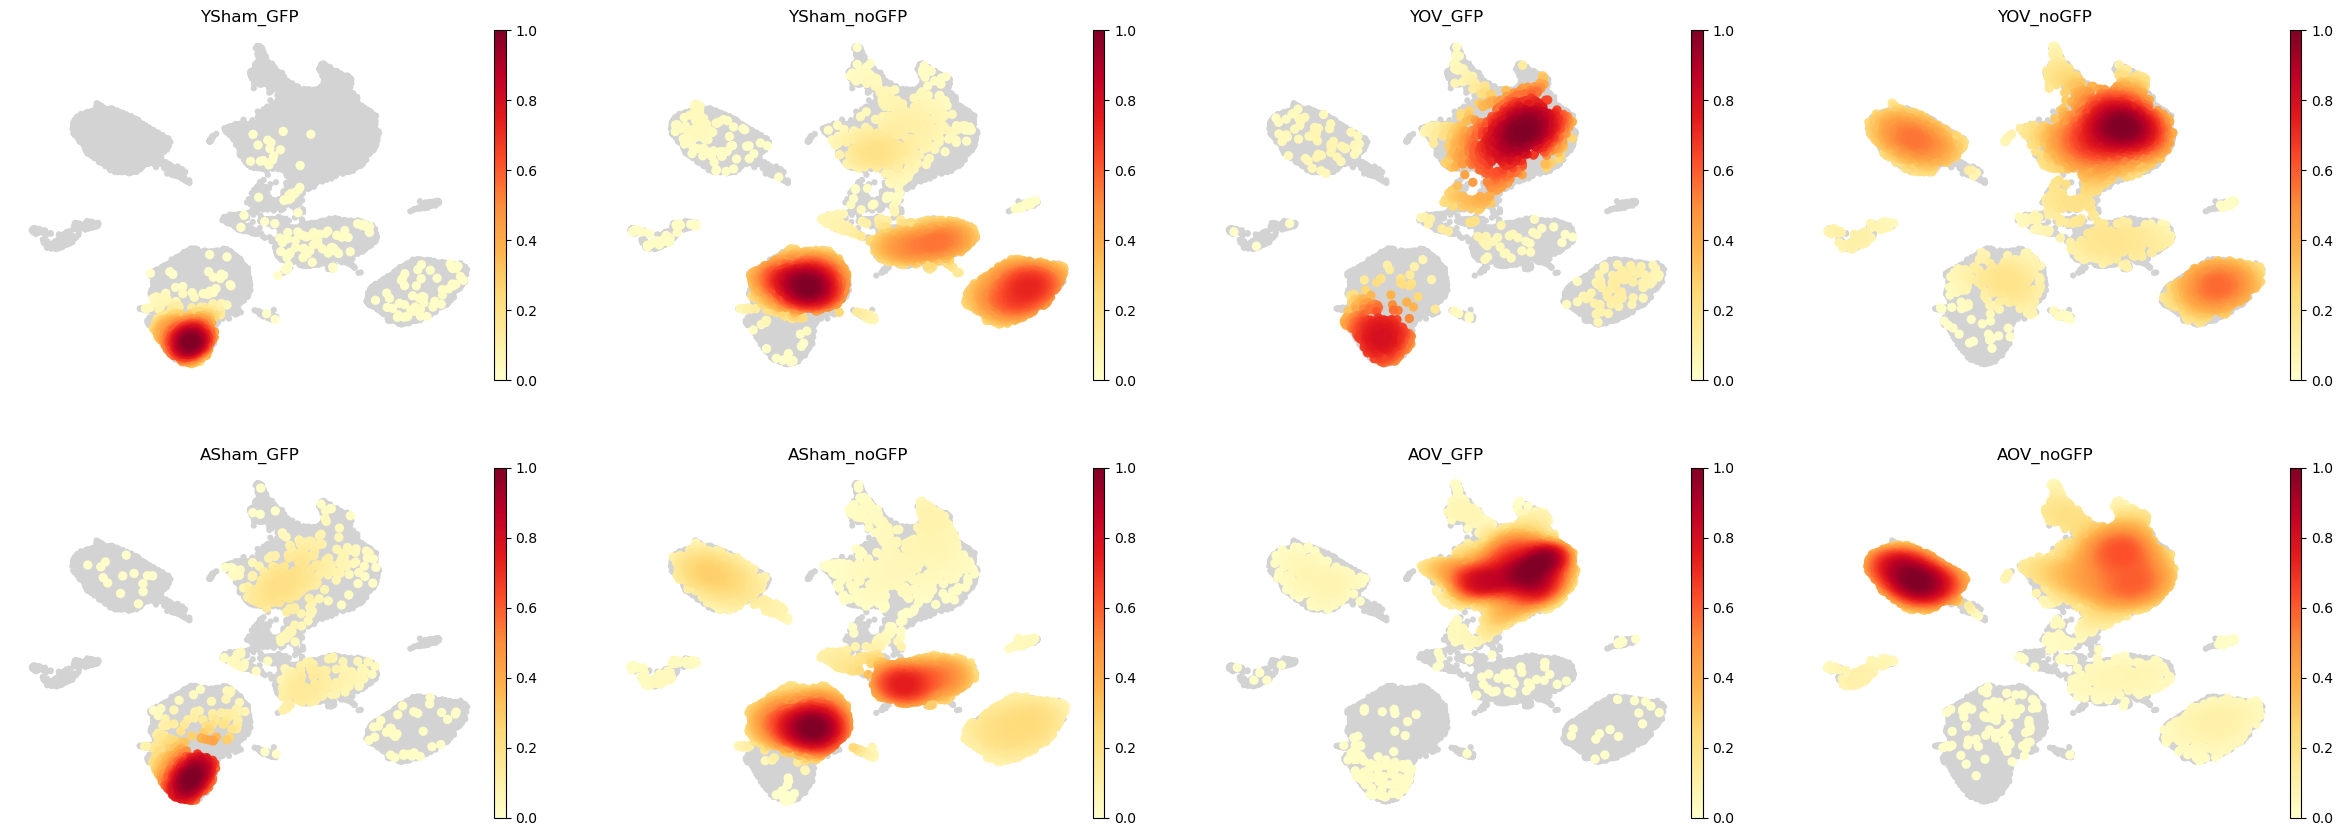

In [46]:
sc.pl.embedding_density(adata_concat, groupby='batch',ncols=4,frameon=False)

In [82]:
adata_concat
#adata_concat.obs['umap_density_batch']
adata_concat.obs[['umap_density_batch','leiden','batch']].to_csv('density_by_cluster.csv')

In [47]:
result = adata_concat.uns['rank_genes_groups']
groups = result['names'].dtype.names
res = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges','pvals','pvals_adj']})
res.to_csv('integrated_cluster_genes.csv')

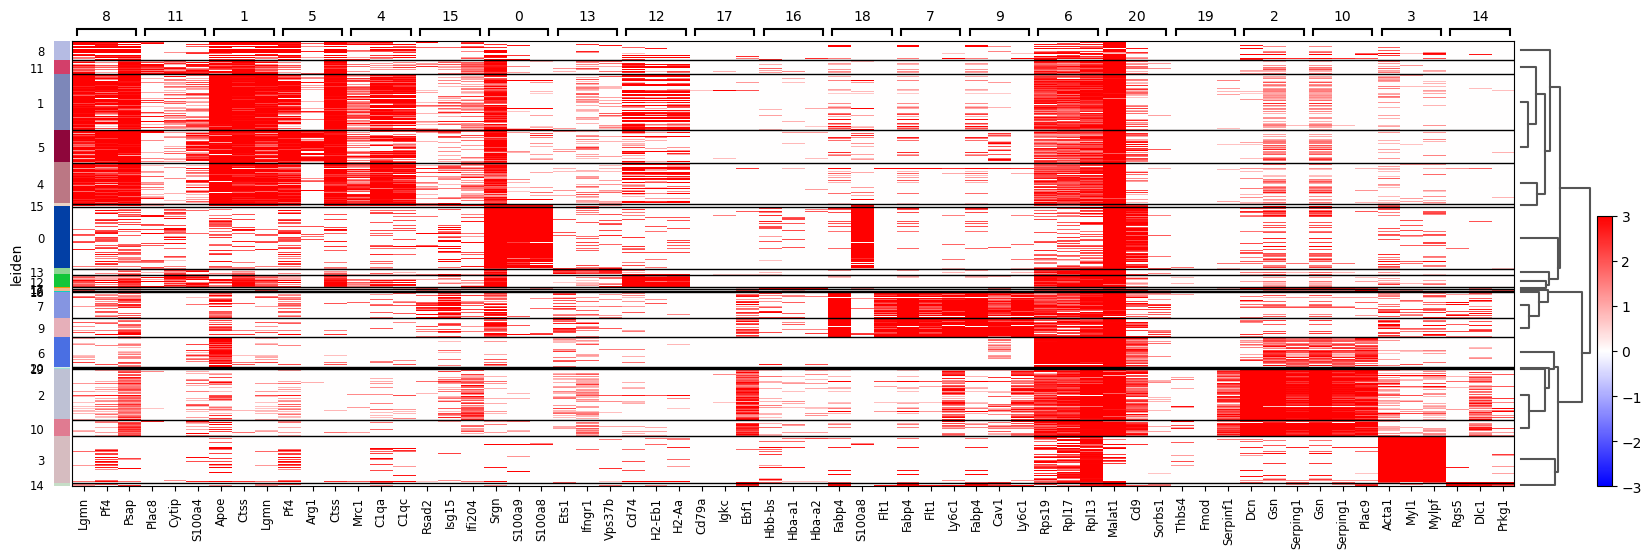

In [49]:
sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes=3,swap_axes=False, 
                                vmin=-3, vmax=3,cmap='bwr',groupby='leiden',
                                show_gene_labels=True,save="_marker_heatmap")

In [50]:
cell_type = {
    "0": "Neutrophils",
    "1": "Lipid-Laden Macrophages",
    "2": "Fibroadipogenic cells I",
    "3": "Mature skeletal muscle" ,
    "4": "Pro-inflamatory Macrophages II",
    "5": "Macrophages III",
    "6": "MuSCs",
    "7": "Endothelial cells I",
    "8": "Macrophages IV",
    "9": "Endothelial cells II",
    "10": "Fibroadipogenic cells II",
    "11": "Macrophages V",
    "12": "Dendritic cells",
    "13": "T cells",
    "14": "Endothelial cells III",
    "15": "Macrophages VI", 
    "16": "Endothelial cells IV",
    "17": "B cells",
    "18": "Endothelial cells V",
    "19": "Fibroblasts",
    "20": "Schwann cells"
}

In [54]:
adata_concat.obs['cell_type'] = adata_concat.obs.leiden.map(cell_type)

In [84]:
from matplotlib import rcParams

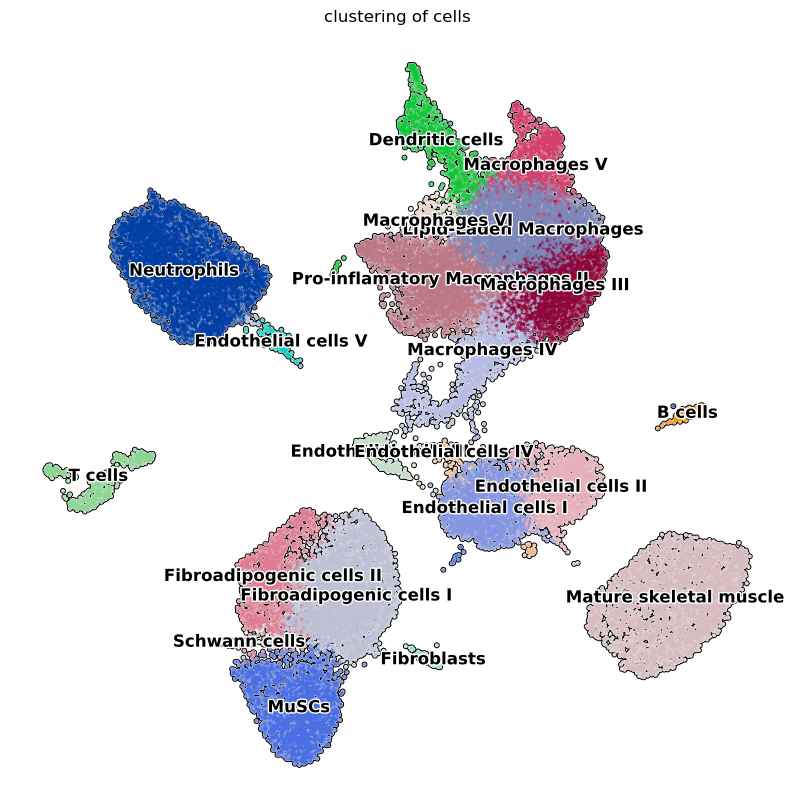

In [57]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata_concat, color='cell_type', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=25,
           title='clustering of cells')

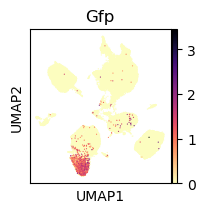

In [78]:
rcParams['figure.figsize'] = 2, 2
sc.pl.umap(adata_concat, color='Gfp',color_map='magma_r')
#sc.pl.umap(adata_concat, color='Gfp',use_raw=True, groups=['YSham_GFP'],color_map='magma_r')
#sc.pl.umap(adata_concat, color='Gfp',use_raw=True, groups=['ASham_GFP'],color_map='magma_r')
#sc.pl.umap(adata_concat, color='Gfp',use_raw=True, groups=['YOV_GFP'],color_map='magma_r')
#sc.pl.umap(adata_concat, color='Gfp',use_raw=True, groups=['AOV_GFP'],color_map='magma_r')

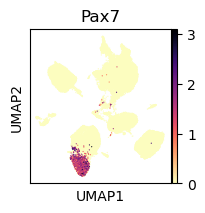

In [79]:
rcParams['figure.figsize'] = 2, 2
sc.pl.umap(adata_concat, color='Pax7',color_map='magma_r')
#sc.pl.umap(adata_concat, color='Pax7',use_raw=True, groups='YSham_GFP',color_map='magma_r')

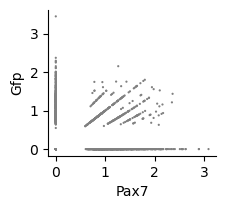

In [90]:
rcParams['figure.figsize'] = 3, 2
sc.pl.scatter(ad, x="Pax7", y="Gfp",size=10)

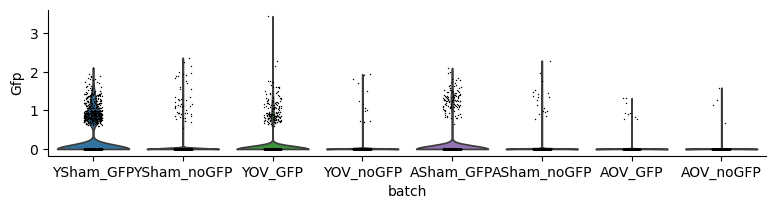

In [93]:
rcParams['figure.figsize'] = 8, 2
sc.pl.violin(ad, "Gfp", "batch")

In [140]:
print(adata_concat.raw)
print(adata_concat.raw.var.shape)

Raw AnnData with n_obs × n_vars = 40761 × 40215
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
(40215, 13)


In [156]:
ad_filtered = adata_concat[((adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) & (adata_concat.raw[: , "Pax7"].X.toarray().flatten() ==0)), :].copy()
#ad_filtered = adata_concat[(adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) , :].copy()
print(ad_filtered)

AnnData object with n_obs × n_vars = 39206 × 4824
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'umap_density_batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'umap', 'umap_density_batch_params'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [157]:
sc.tl.embedding_density(ad_filtered, groupby='batch')

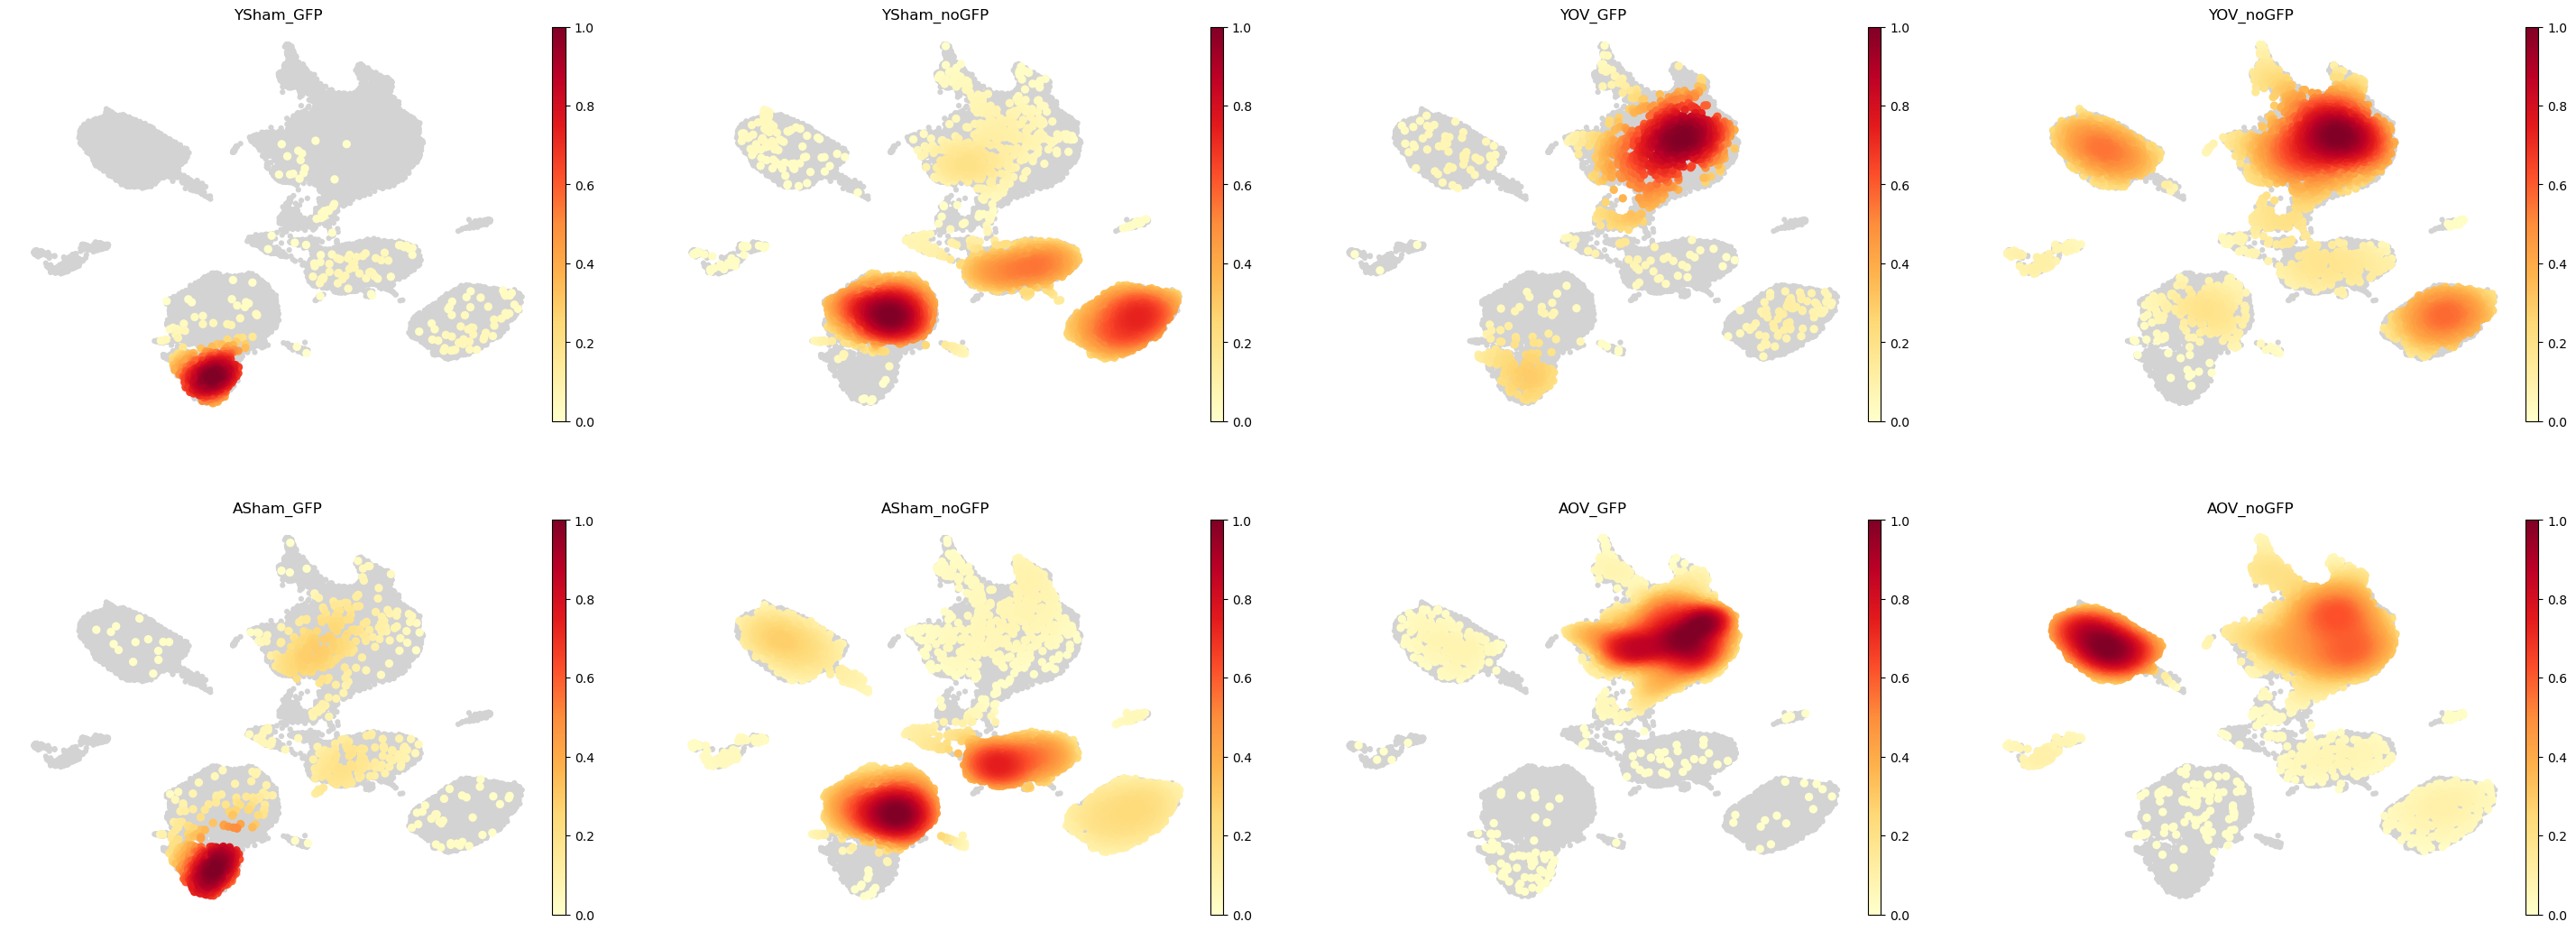

In [158]:
rcParams['figure.figsize'] = 8, 6
sc.pl.embedding_density(ad_filtered, groupby='batch',ncols=4,frameon=False)

In [159]:
ad_filtered.obs[['umap_density_batch','leiden','batch']].to_csv('density_by_cluster_filtered.csv')

In [80]:
pip install mellon

DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [15]:
import mellon
import palantir
import subprocess

In [16]:
#pip install jaxlib
subprocess.run(['nvidia-smi'])

Tue Mar  4 04:45:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 11.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5000 Ada Gene...    On  |   00000000:51:00.0 Off |                  Off |
| 30%   32C    P8              5W /  250W |    2766MiB /  32760MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

CompletedProcess(args=['nvidia-smi'], returncode=0)

In [20]:
import jax

In [22]:
jax.devices()

[CpuDevice(id=0)]

In [2]:
model = mellon.DensityEstimator()

In [6]:
ad = sc.read("Harmony_integrated_data.h5ad")

In [9]:
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca_harmony", n_components=50)

In [10]:
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2025-03-04 04:40:30,103] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (40,761) and rank = 1.0.
[2025-03-04 04:40:30,104] [INFO    ] Computing nearest neighbor distances.
[2025-03-04 04:41:18,925] [INFO    ] Using embedding dimensionality d=50. Use d_method="fractal" to enable effective density normalization.
[2025-03-04 04:41:19,161] [INFO    ] Using covariance function Matern52(ls=0.03482935688526498).
[2025-03-04 04:41:19,166] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2025-03-04 04:41:34,746] [INFO    ] Using rank 5,000 covariance representation.
[2025-03-04 04:41:36,630] [INFO    ] Running inference using L-BFGS-B.


In [23]:
predictor = model.predict

ad.obs["mellon_log_density"] = log_density
ad.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2025-03-04 04:50:02,280] [INFO    ] Computing predictive function.


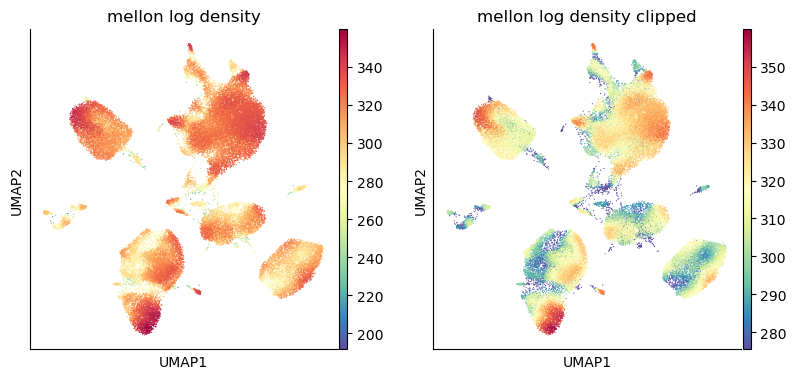

In [27]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap",groups='YSham_GFP'
)

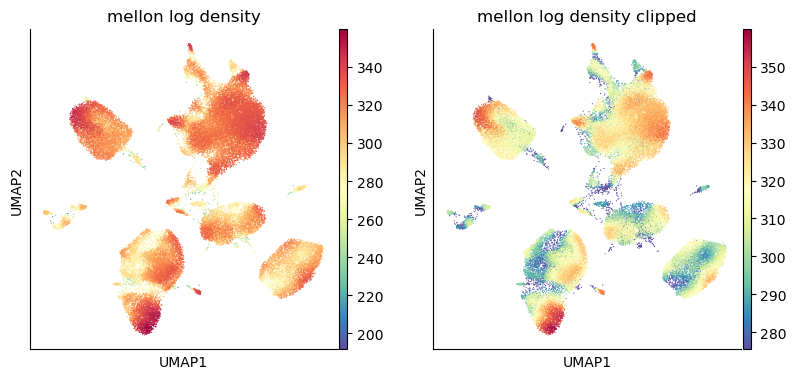

In [28]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap",groups='YOV_GFP'
)

In [37]:
ad

AnnData object with n_obs × n_vars = 40761 × 4824
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'umap', 'DM_EigenValues'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'DM_Kernel', 'DM_Similarity'

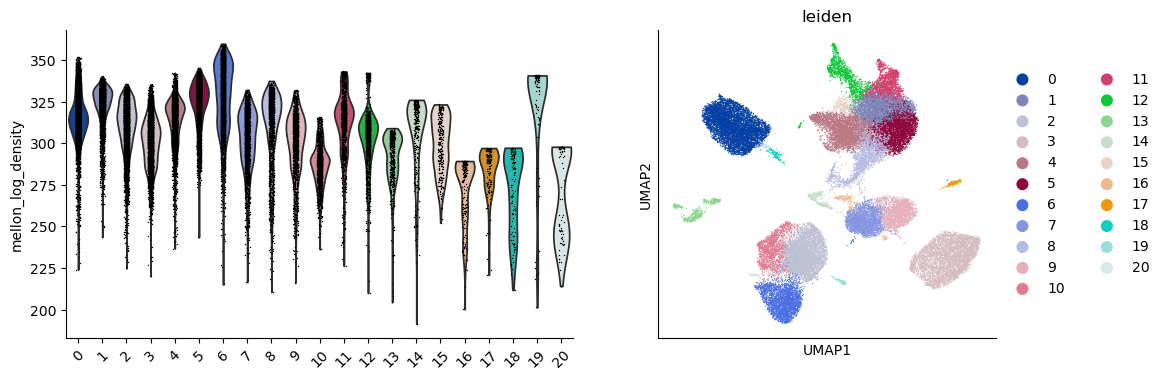

In [41]:
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(ad, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

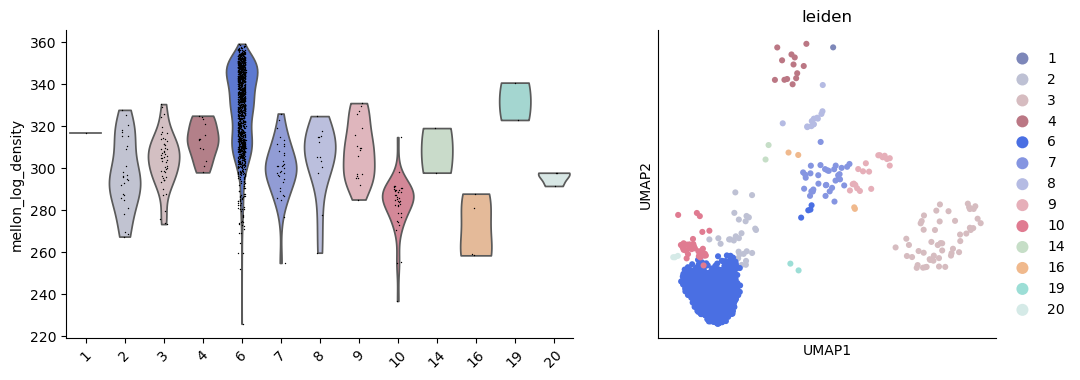

In [48]:
tmp = ad[ad.obs["batch"]=="YSham_GFP"].copy()
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(tmp, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(tmp, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

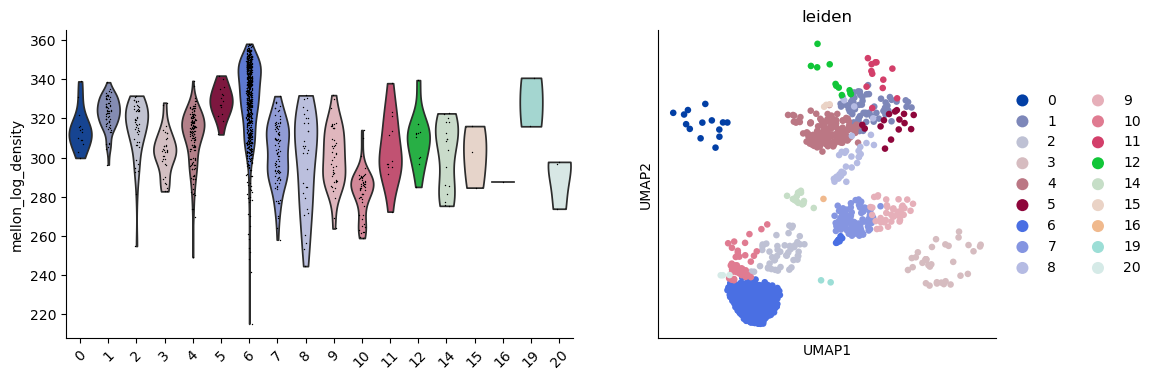

In [49]:
tmp1 = ad[ad.obs["batch"]=="ASham_GFP"].copy()
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(tmp1, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(tmp1, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

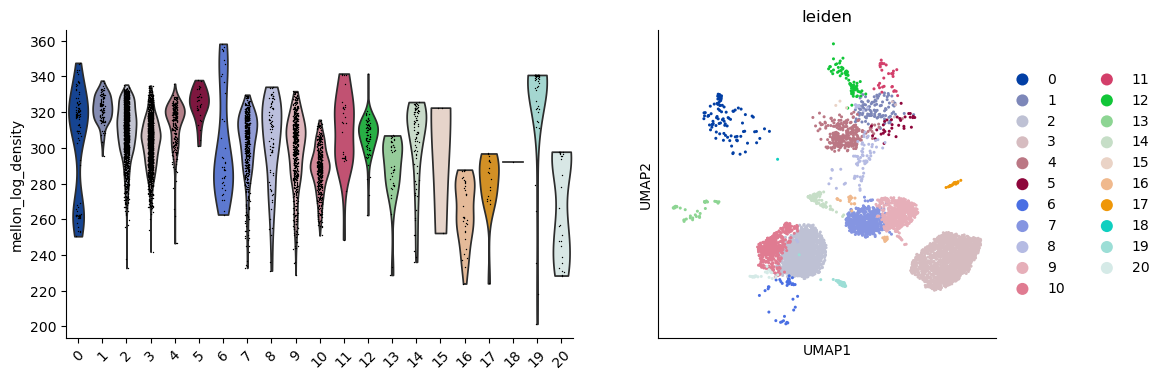

In [50]:
tmp0 = ad[ad.obs["batch"]=="YSham_noGFP"].copy()
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(tmp0, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(tmp0, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

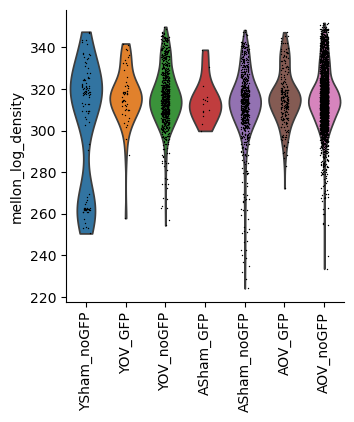

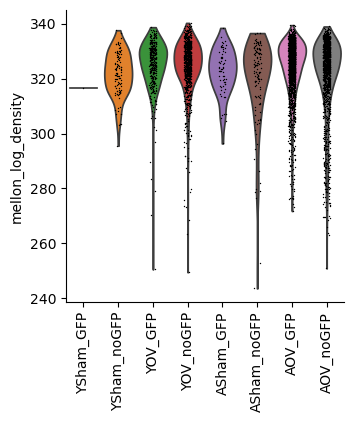

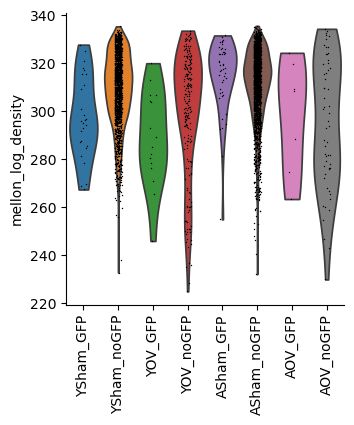

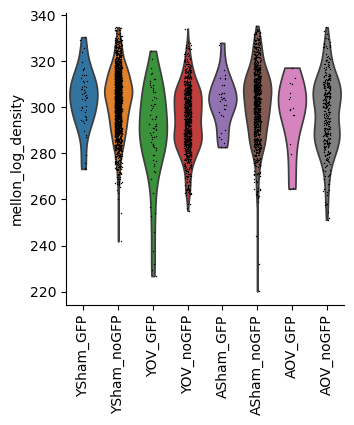

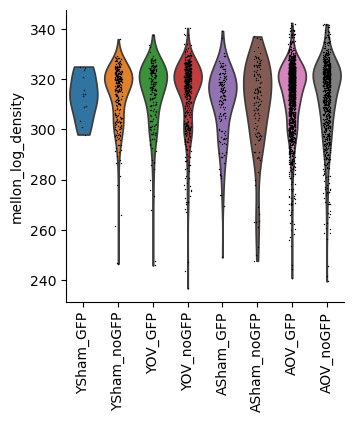

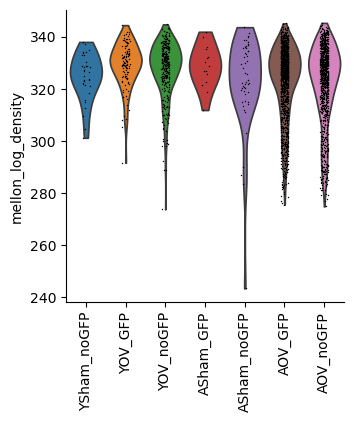

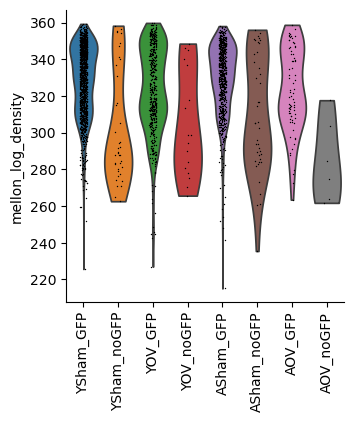

In [60]:
tmp0 = ad[ad.obs["leiden"]=="0"].copy()
sc.pl.violin(tmp0, "mellon_log_density", "batch", rotation=90)

tmp1 = ad[ad.obs["leiden"]=="1"].copy()
sc.pl.violin(tmp1, "mellon_log_density", "batch", rotation=90)

tmp2 = ad[ad.obs["leiden"]=="2"].copy()
sc.pl.violin(tmp2, "mellon_log_density", "batch", rotation=90)

tmp3 = ad[ad.obs["leiden"]=="3"].copy()
sc.pl.violin(tmp3, "mellon_log_density", "batch", rotation=90)

tmp4 = ad[ad.obs["leiden"]=="4"].copy()
sc.pl.violin(tmp4, "mellon_log_density", "batch", rotation=90)

tmp5 = ad[ad.obs["leiden"]=="5"].copy()
sc.pl.violin(tmp5, "mellon_log_density", "batch", rotation=90)

tmp6 = ad[ad.obs["leiden"]=="6"].copy()
sc.pl.violin(tmp6, "mellon_log_density", "batch", rotation=90)


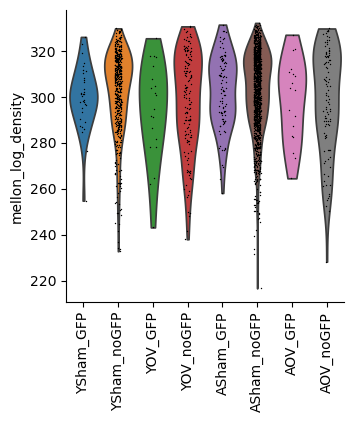

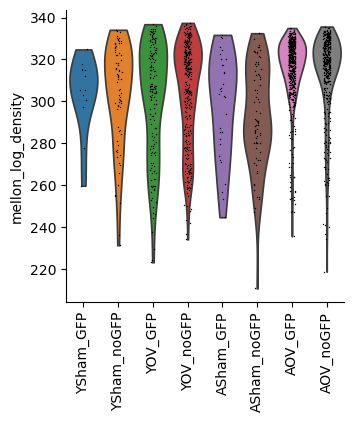

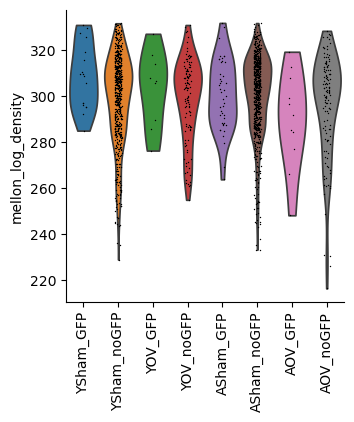

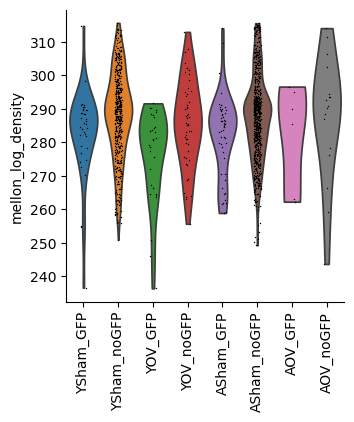

In [61]:
tmp0 = ad[ad.obs["leiden"]=="7"].copy()
sc.pl.violin(tmp0, "mellon_log_density", "batch", rotation=90)

tmp1 = ad[ad.obs["leiden"]=="8"].copy()
sc.pl.violin(tmp1, "mellon_log_density", "batch", rotation=90)

tmp2 = ad[ad.obs["leiden"]=="9"].copy()
sc.pl.violin(tmp2, "mellon_log_density", "batch", rotation=90)

tmp3 = ad[ad.obs["leiden"]=="10"].copy()
sc.pl.violin(tmp3, "mellon_log_density", "batch", rotation=90)

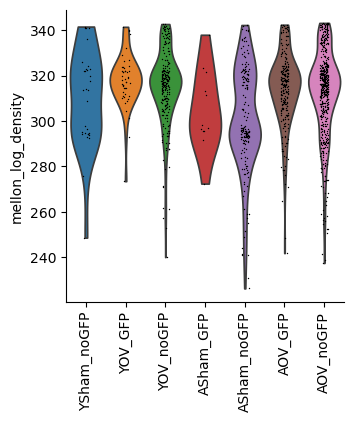

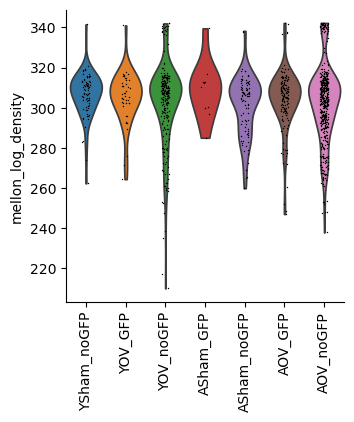

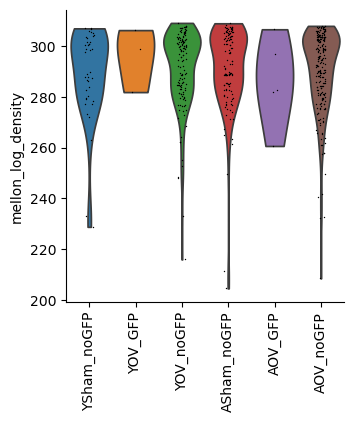

In [62]:
tmp4 = ad[ad.obs["leiden"]=="11"].copy()
sc.pl.violin(tmp4, "mellon_log_density", "batch", rotation=90)

tmp5 = ad[ad.obs["leiden"]=="12"].copy()
sc.pl.violin(tmp5, "mellon_log_density", "batch", rotation=90)

tmp6 = ad[ad.obs["leiden"]=="13"].copy()
sc.pl.violin(tmp6, "mellon_log_density", "batch", rotation=90)


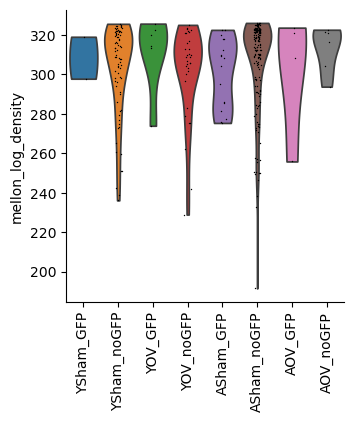

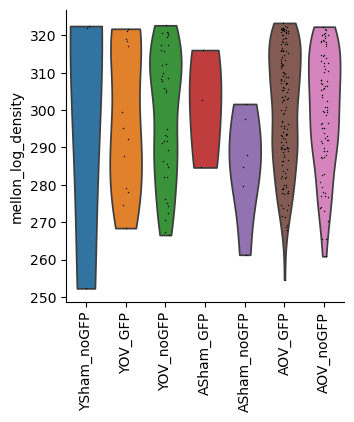

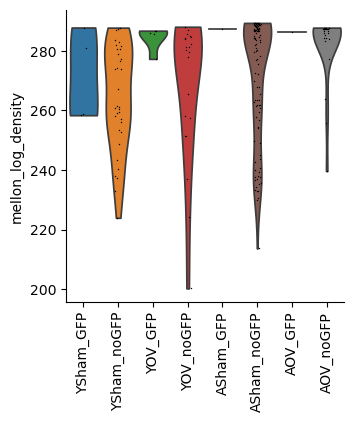

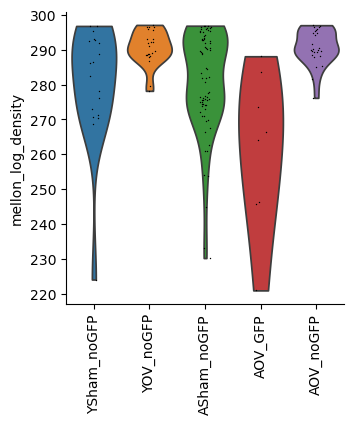

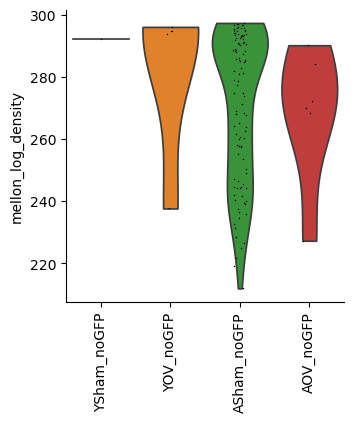

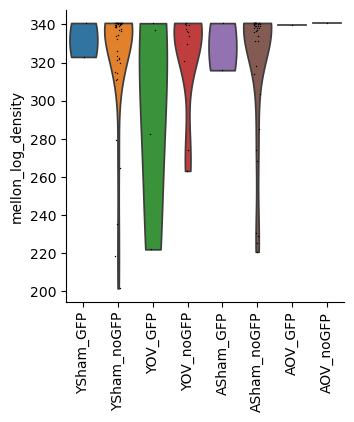

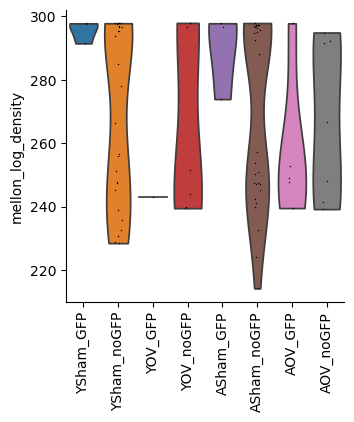

In [63]:
tmp3 = ad[ad.obs["leiden"]=="14"].copy()
sc.pl.violin(tmp3, "mellon_log_density", "batch", rotation=90)

tmp4 = ad[ad.obs["leiden"]=="15"].copy()
sc.pl.violin(tmp4, "mellon_log_density", "batch", rotation=90)

tmp5 = ad[ad.obs["leiden"]=="16"].copy()
sc.pl.violin(tmp5, "mellon_log_density", "batch", rotation=90)

tmp6 = ad[ad.obs["leiden"]=="17"].copy()
sc.pl.violin(tmp6, "mellon_log_density", "batch", rotation=90)

tmp4 = ad[ad.obs["leiden"]=="18"].copy()
sc.pl.violin(tmp4, "mellon_log_density", "batch", rotation=90)

tmp5 = ad[ad.obs["leiden"]=="19"].copy()
sc.pl.violin(tmp5, "mellon_log_density", "batch", rotation=90)

tmp6 = ad[ad.obs["leiden"]=="20"].copy()
sc.pl.violin(tmp6, "mellon_log_density", "batch", rotation=90)

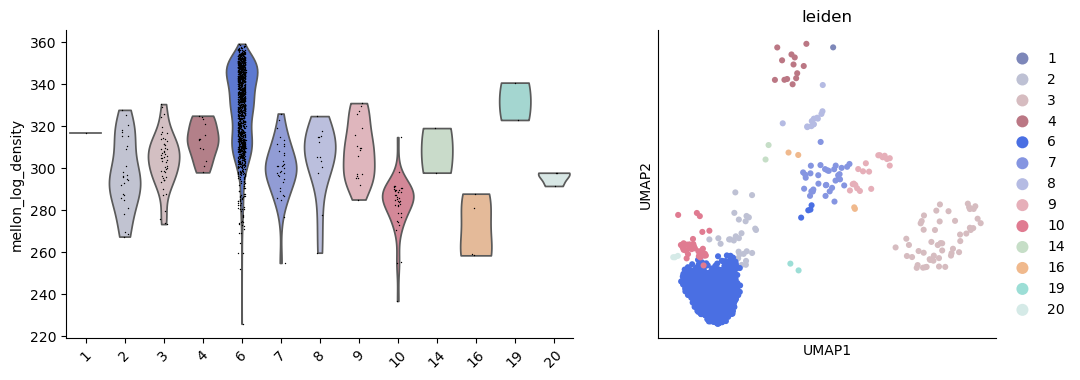

In [68]:
YSG = ad[ad.obs["batch"]=="YSham_GFP"].copy()
#dm_res = palantir.utils.run_diffusion_maps(YSG, pca_key="X_pca_harmony", n_components=50)
#model = mellon.DensityEstimator()
#log_density = model.fit_predict(YSG.obsm["DM_EigenVectors"])
#predictor = model.predict

#YSG.obs["mellon_log_density"] = log_density
#YSG.obs["mellon_log_density_clipped"] = np.clip(
#    log_density, *np.quantile(log_density, [0.05, 1])
#)
#sc.pl.scatter(
#    YSG, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
#)
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(YSG, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(YSG, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

[2025-03-04 05:33:11,696] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,660) >= n_samples (1,660) and rank = 1.0.
[2025-03-04 05:33:11,699] [INFO    ] Computing nearest neighbor distances.
[2025-03-04 05:33:11,824] [INFO    ] Using embedding dimensionality d=50. Use d_method="fractal" to enable effective density normalization.
[2025-03-04 05:33:11,827] [INFO    ] Using covariance function Matern52(ls=0.9363017085475646).
[2025-03-04 05:33:11,866] [INFO    ] Using rank 1,660 covariance representation.
[2025-03-04 05:33:11,914] [INFO    ] Running inference using L-BFGS-B.
[2025-03-04 05:33:13,615] [INFO    ] Computing predictive function.


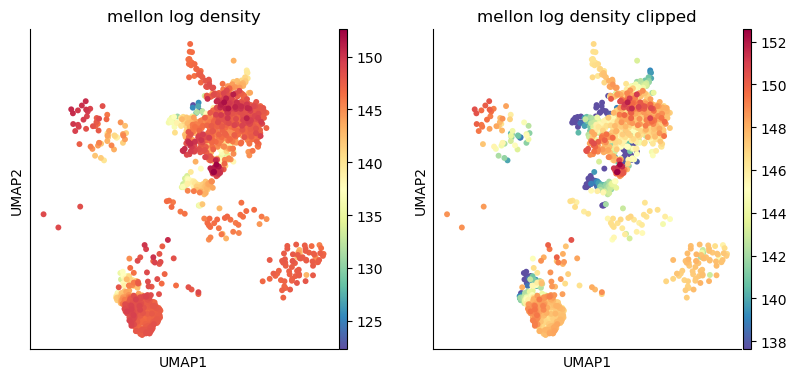

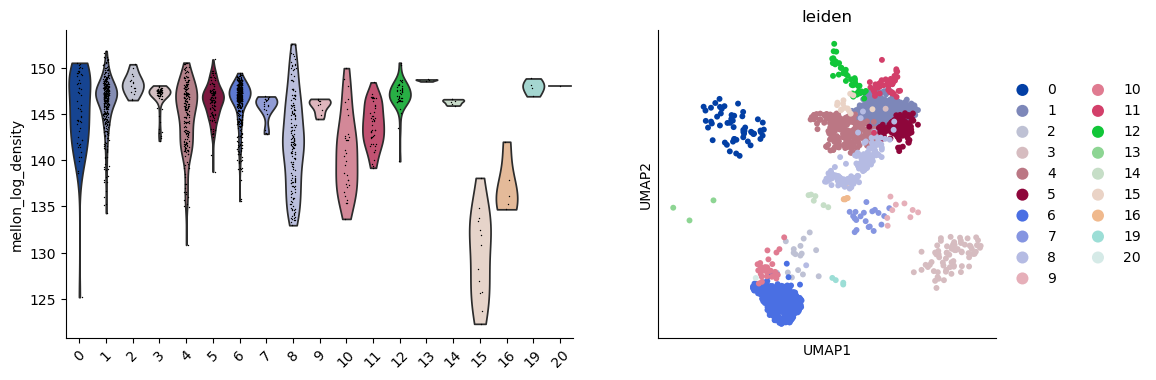

In [65]:
YOG = ad[ad.obs["batch"]=="YOV_GFP"].copy()
dm_res = palantir.utils.run_diffusion_maps(YOG, pca_key="X_pca_harmony", n_components=50)
model = mellon.DensityEstimator()
log_density = model.fit_predict(YOG.obsm["DM_EigenVectors"])
predictor = model.predict

YOG.obs["mellon_log_density"] = log_density
YOG.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(
    YOG, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(YOG, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(YOG, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

[2025-03-04 05:33:17,079] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,337) >= n_samples (1,337) and rank = 1.0.
[2025-03-04 05:33:17,080] [INFO    ] Computing nearest neighbor distances.
[2025-03-04 05:33:17,162] [INFO    ] Using embedding dimensionality d=50. Use d_method="fractal" to enable effective density normalization.
[2025-03-04 05:33:17,163] [INFO    ] Using covariance function Matern52(ls=1.242510728425651).
[2025-03-04 05:33:17,197] [INFO    ] Using rank 1,337 covariance representation.
[2025-03-04 05:33:17,232] [INFO    ] Running inference using L-BFGS-B.
[2025-03-04 05:33:18,566] [INFO    ] Computing predictive function.


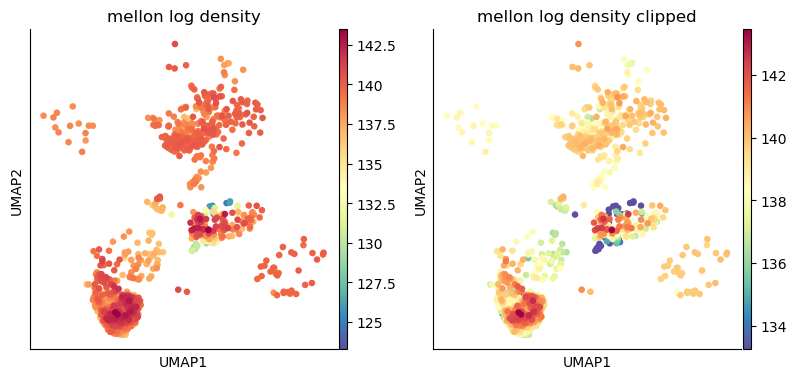

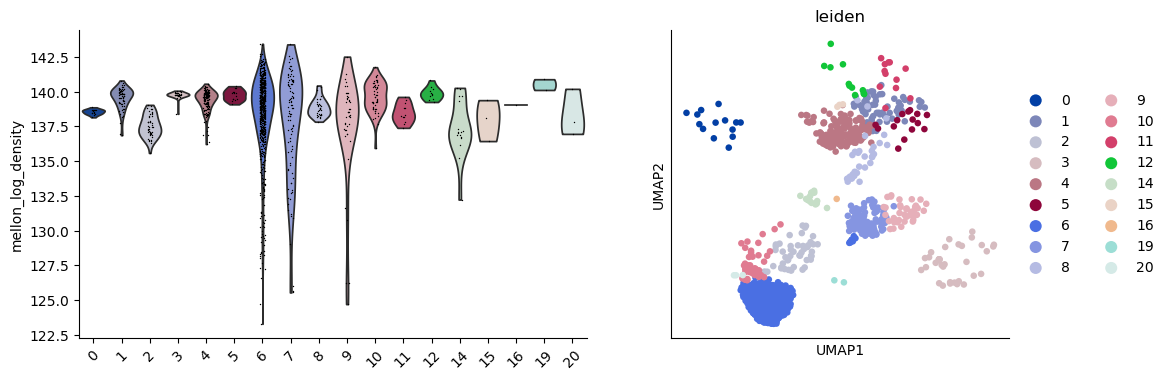

In [66]:
ASG = ad[ad.obs["batch"]=="ASham_GFP"].copy()
dm_res = palantir.utils.run_diffusion_maps(ASG, pca_key="X_pca_harmony", n_components=50)
model = mellon.DensityEstimator()
log_density = model.fit_predict(ASG.obsm["DM_EigenVectors"])
predictor = model.predict

ASG.obs["mellon_log_density"] = log_density
ASG.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(
    ASG, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(ASG, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ASG, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()

[2025-03-04 05:33:22,857] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (6,622) and rank = 1.0.
[2025-03-04 05:33:22,857] [INFO    ] Computing nearest neighbor distances.
[2025-03-04 05:33:24,458] [INFO    ] Using embedding dimensionality d=50. Use d_method="fractal" to enable effective density normalization.
[2025-03-04 05:33:24,462] [INFO    ] Using covariance function Matern52(ls=0.38417922966926865).
[2025-03-04 05:33:24,464] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2025-03-04 05:33:27,555] [INFO    ] Using rank 5,000 covariance representation.
[2025-03-04 05:33:28,270] [INFO    ] Running inference using L-BFGS-B.
[2025-03-04 05:33:35,714] [INFO    ] Computing predictive function.


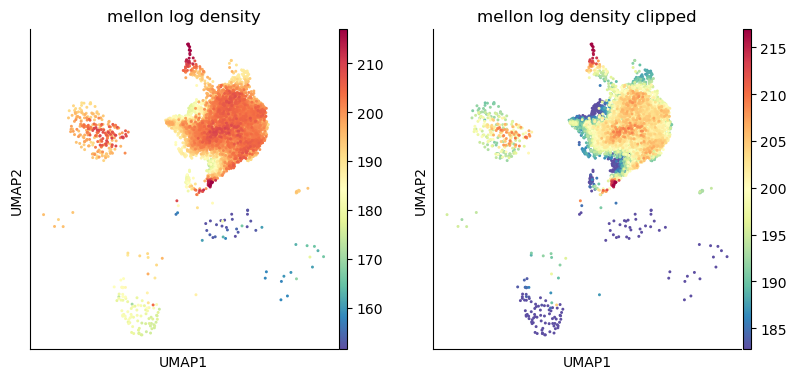

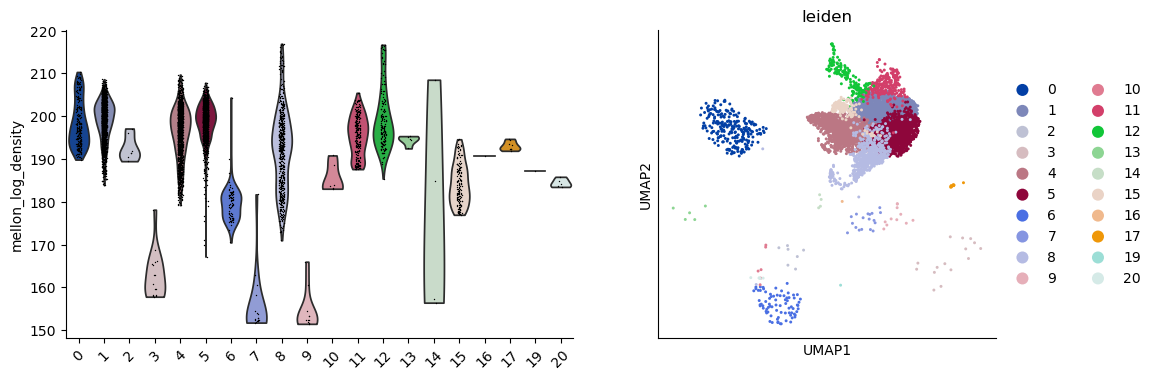

In [67]:
AOG = ad[ad.obs["batch"]=="AOV_GFP"].copy()
dm_res = palantir.utils.run_diffusion_maps(AOG, pca_key="X_pca_harmony", n_components=50)
model = mellon.DensityEstimator()
log_density = model.fit_predict(AOG.obsm["DM_EigenVectors"])
predictor = model.predict

AOG.obs["mellon_log_density"] = log_density
AOG.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(
    AOG, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)
fig, (ax1, ax2) = pl.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(AOG, "mellon_log_density", "leiden", rotation=45, ax=ax1, show=False)
sc.pl.scatter(AOG, color="leiden", basis="umap", ax=ax2, show=False)
pl.show()